In [1]:
from importlib import reload
from typing import List

import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

import spectrum_painting_data as sp_data
import spectrum_painting_model as sp_model
import spectrum_painting_plotting as sp_plot
import spectrum_painting_predict as sp_predict
import spectrum_painting_training as sp_training

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Number of training images: 205
Number of testing images: 89


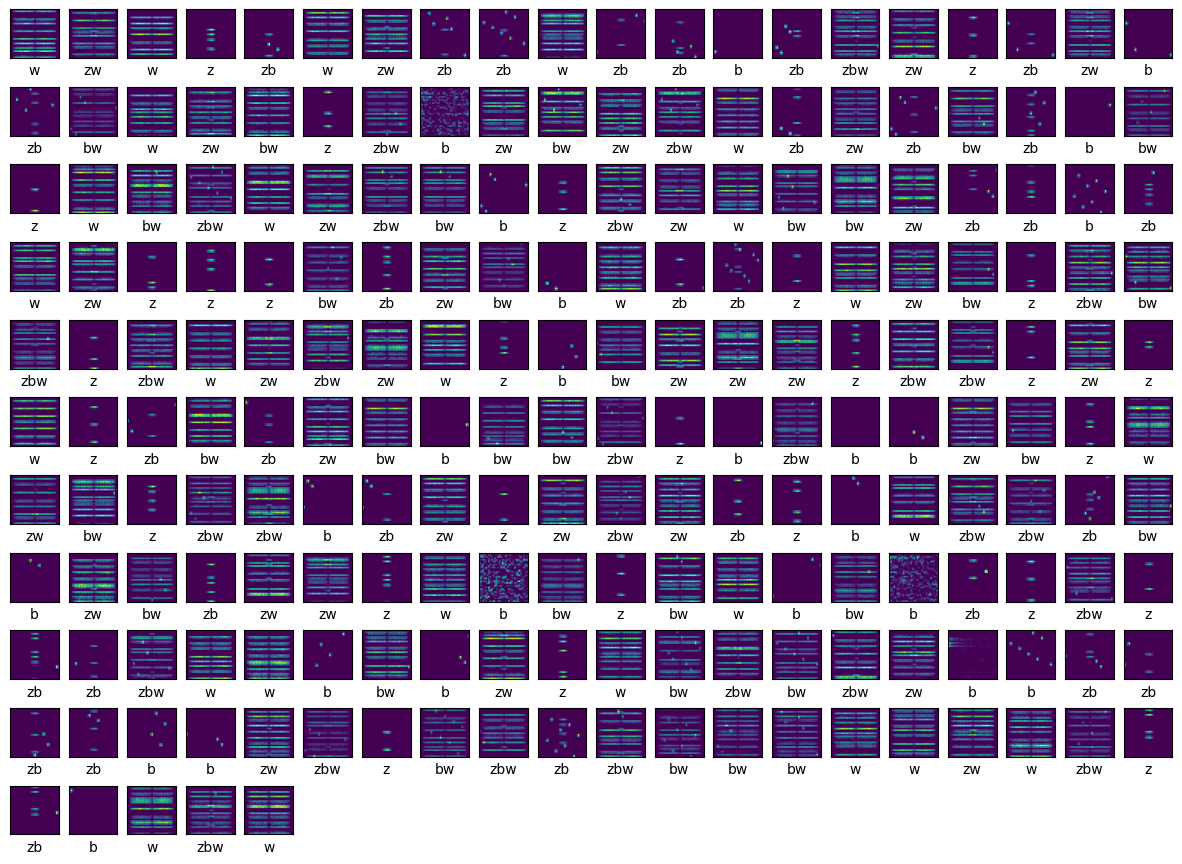

In [2]:
# Reload spectrum painting module in case the code changed
# and you want what is executed to be what you told the computer
# to do.
reload(sp_data)
reload(sp_plot)
reload(sp_predict)
reload(sp_training)

spectrograms = sp_data.load_spectrograms(data_dir="data/matlab",
                                         snr=30,
                                         # 20 MHz
                                         sample_rate=20000000)

train_test_sets = sp_training.create_spectrum_painting_train_test_sets(
    spectrograms=spectrograms,
    options=sp_training.SpectrumPaintingTrainingOptions(
        spectrogram_length=4000,
        downsample_resolution=32,
        k=3,
        l=1,
        d=1,
        color_depth=256
    )
)

print(f"Number of training images: {len(train_test_sets.y_train)}")
print(f"Number of testing images: {len(train_test_sets.y_test)}")
sp_plot.plot_train_images(train_test_sets.x_train_augmented, train_test_sets.y_train, train_test_sets.label_names)

(32, 32)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 32, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 26, 26, 64)           3200      ['input_1[0][0]']             
                                                                                                  
 conv2d_3 (Conv2D)           (None, 26, 26, 64)           3200      ['input_2[0][0]']             
                                                                                     

2024-05-23 13:52:13.912631: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-05-23 13:52:13.912648: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-23 13:52:13.912654: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-23 13:52:13.912683: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-23 13:52:13.912699: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


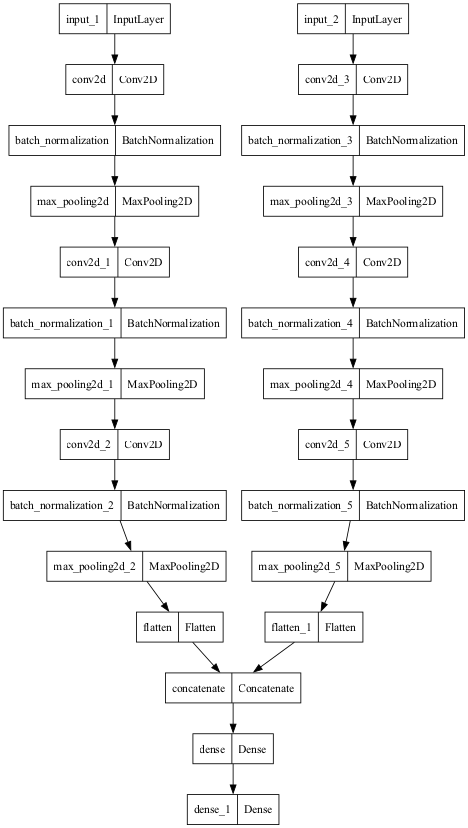

In [3]:
reload(sp_model)

image_shape = train_test_sets.x_train_augmented[0].shape
print(image_shape)

tf_model = sp_model.create_tensorflow_model(image_shape, len(train_test_sets.label_names))
tf_model.summary()
tf.keras.utils.plot_model(tf_model, to_file="output/model.png", dpi=60)


2024-05-23 13:52:14.790599: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


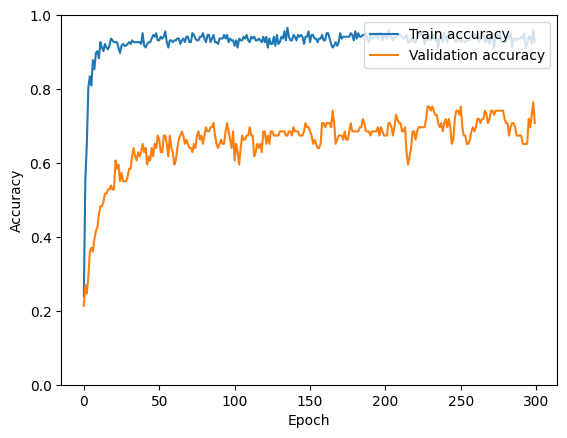

Final loss: 1.375960, final accuracy: 0.707865
INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


In [4]:
reload(sp_model)
history = sp_model.fit_model(tf_model, train_test_sets, epochs=300)

sp_plot.plot_model_accuracy_epochs(history)

final_loss, final_acc = tf_model.evaluate([train_test_sets.x_test_augmented, train_test_sets.x_test_painted],
                                          train_test_sets.y_test,
                                          verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

output_file = "output/spectrum-painting-model.keras"

tf.saved_model.save(tf_model, "output/")
tf_model.save(output_file)


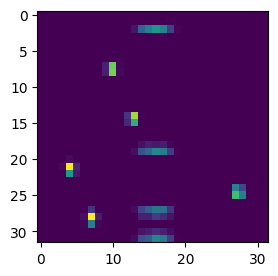

zb


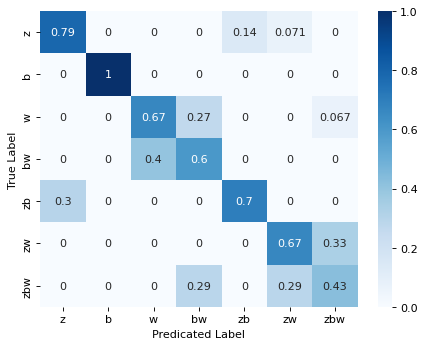

In [5]:
reload(sp_predict)
reload(sp_plot)

# Predict with full Tensorflow
test_img_augmented = train_test_sets.x_test_augmented[17]
test_img_painted = train_test_sets.x_test_painted[17]

plt.figure(figsize=(3, 3))
plt.imshow(test_img_augmented, cmap='viridis')
plt.show()

prediction = sp_predict.predict_full_model(tf_model, test_img_augmented, test_img_painted)

print(train_test_sets.label_names[prediction])

tf_model_y_predictions = [sp_predict.predict_full_model(tf_model, x_a, x_p) for (x_a, x_p) in
                          zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)]

sp_plot.plot_confusion_matrix(tf_model_y_predictions, train_test_sets.y_test, train_test_sets.label_names)

In [6]:
tflite_model = sp_model.convert_to_tensorflow_lite(tf_model, train_test_sets.x_train_augmented,
                                                   train_test_sets.x_train_painted)
print(f"Done. Model size = {len(tflite_model) // 1000} KB")

# Save the model.
with open('output/spectrum-painting-model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpxvmq36kh/assets


INFO:tensorflow:Assets written to: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpxvmq36kh/assets
/Users/sethd/Desktop/spectrum-painting/venv/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-05-23 13:52:50.259368: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-05-23 13:52:50.259382: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-05-23 13:52:50.259559: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/81/3wz7wxg90f3df6qvy1xbf71m0000gn/T/tmpxvmq36kh
2024-05-23 13:52:50.261280: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-05-23 13:52:50.261286: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/81/3wz7wxg90f3

Done. Model size = 151 KB


fully_quantize: 0, inference_type: 6, input_inference_type: UINT8, output_inference_type: UINT8


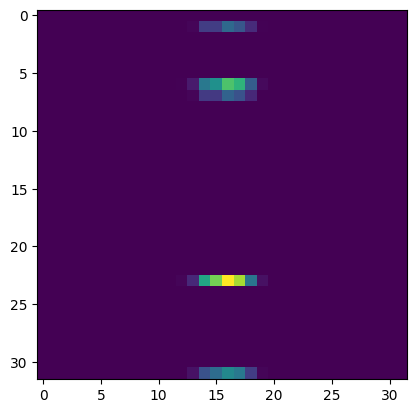

Prediction: z


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
reload(sp_predict)

# Test with Tensorflow Lite
test_img_augmented = train_test_sets.x_test_augmented[1]
test_img_painted = train_test_sets.x_test_painted[1]

plt.imshow(test_img_augmented, cmap="viridis")
plt.show()

prediction = sp_predict.predict_lite_model(tflite_model, test_img_augmented, test_img_painted)
print(f"Prediction: {train_test_sets.label_names[prediction]}")

Lite model accuracy = 0.6741573033707865


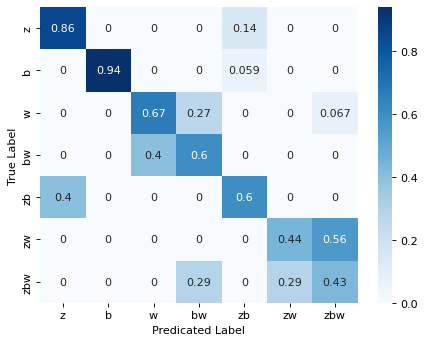

In [8]:
tflite_model_y_predictions: List[int] = []

for x_aug, x_painted in list(zip(train_test_sets.x_test_augmented, train_test_sets.x_test_painted)):
    tflite_model_y_predictions.append(sp_predict.predict_lite_model(tflite_model, x_aug, x_painted))

accuracy = np.sum(train_test_sets.y_test == tflite_model_y_predictions) / len(train_test_sets.y_test)

print(f"Lite model accuracy = {accuracy}")
sp_plot.plot_confusion_matrix(np.asarray(tflite_model_y_predictions), train_test_sets.y_test,
                              train_test_sets.label_names)

(32, 32)


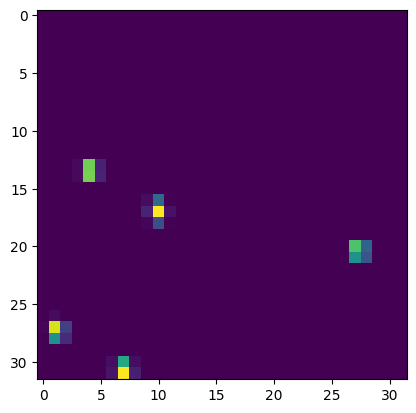

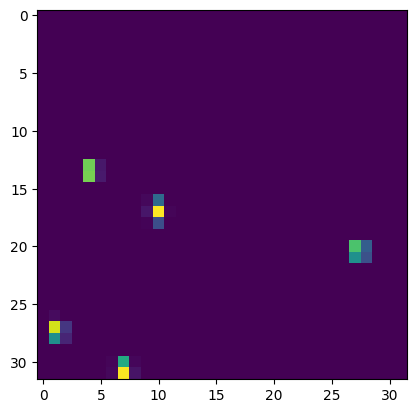

In [9]:
test_img_augmented = train_test_sets.x_test_augmented[9]
test_img_painted = train_test_sets.x_test_painted[9]

print(test_img_augmented.shape)

plt.imshow(test_img_augmented, cmap='viridis')
plt.show()

plt.imshow(test_img_painted, cmap='viridis')
plt.show()

test_img_augmented.shape += (1,)
test_img_augmented = (np.expand_dims(test_img_augmented, 0))
test_img_augmented = test_img_augmented.astype(np.uint8)

test_img_painted.shape += (1,)
test_img_painted = (np.expand_dims(test_img_painted, 0))
test_img_painted = test_img_painted.astype(np.uint8)

with open('output/augmented_image.bytes', 'wb') as f:
    f.write(test_img_augmented.flatten())

with open('output/painted_image.bytes', 'wb') as f:
    f.write(test_img_painted.flatten())